# Specific heat capacity
This notebook can be used to calculate and visualize all the relevant values needed to determine the molar heat capacity of solid samples. It is also the code used to calculate the values meentiooned in our report.  
  
It is highly recommended to read the report before trying to figure out what the code does.

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import errors
from statistics import mean 
import pandas as pd
import helpers
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import *
from matplotlib import gridspec

**Parameters**

In [ ]:
end_h_step = 340 
window_size =16

**Read in the data**

In [ ]:
#raw data
copper    = helpers.read_in('data/Copper_Linsi_Serck.csv',129.20000674,827.20004314,window=window_size,)
water     = helpers.read_in('data/Water_Linsi_Serck.csv',97.20000507,532.00002775,window=window_size,sign_b=-1)
aluminium = helpers.read_in('data/Alu_Linsi_Serck.csv',82.93333766,708.53337029,window=window_size)

#manually created "ideal values"
ideals={
    'Copper':pd.read_csv('ideal_copper.csv'),
    'Water':pd.read_csv('ideal_water.csv'),
    'Alu':pd.read_csv('ideal_alu.csv')}

### Define which Probe to use.  
the variable **data** defines which probe will be analized.  
Note that for every probe, water will be used as well for c_add. all variables referring to waater are named w_variable


In [60]:
data = aluminium ##      **The Sample we are using**

meta=helpers.variables[name]#take a look in helpers.py to see which data meta includes.
name = data['name']

w_meta = helpers.variables['Water']  

**Key Temperatures**  
  
  $$T_s,T_2,T_g$$

We determine the three key temperatures we use to do our calculations. They represent the temperature in our average window at the times turning on the heating, {end_h_step} datapoints after turing of the heating, and 10 minutes after turning off the heating.

In [ ]:
#water
w_initial_temp  = water['smooth_temp'][w_meta['i_start_h']] #T_s
w_temp_2        = water['smooth_temp'][w_meta['i_end_h']+end_h_step]#t_2
w_temp_g        = water['smooth_temp'][w_meta['i_g']] #t_g

#sample
initial_temp    = data['smooth_temp'][meta['i_start_h']]
temp_2          = data['smooth_temp'][meta['i_end_h']+end_h_step]
temp_g          = data['smooth_temp'][meta['i_g']]

### Integral ts-tg  
**Note:** We use the values in our rolling average, to get the area using np.trapz().  
Therefore we have to subtract the area (t_g-t_1*initial_temperature)    

In [ ]:
#water
w_initial_area    = w_initial_temp*(w_meta['t_g']-w_meta['t_start_h']) #the area  from 0 to init_temp. (A square.)
w_smooth_integral = np.trapz(water['temp'][w_meta['i_start_h']:w_meta['i_g']], water['time'][w_meta['i_start_h']:w_meta['i_g']])-w_initial_area

#sample
initial_area      = initial_temp*(meta['t_g']-meta['t_start_h']) #the area  from 0 to init_temp.
smooth_integral   = np.trapz(data['smooth_temp'][meta['i_start_h']:meta['i_g']], data['time'][meta['i_start_h']:meta['i_g']])-initial_area

### Linear Regression 
Using linear regressioon can improve the estimate on the gradient T*

In [63]:
w_regression = helpers.plot_linear_regression(data=water,meta=w_meta,end_h_step=end_h_step)
w_gradient_regression=float(w_regression.coef_[0])


lin_regression = helpers.plot_linear_regression(data=data,meta=meta,end_h_step=end_h_step)
gradient_regression = float(lin_regression.coef_[0])
# y_offset = lin_regression.intercept_

### Calculating C_add (Water) 
We calculate the C_add therefore we have to determine several other values first. The gradient is one of them.  
**Note:** if preffered use the gradient obtained from the linear regressioon model. Do not forget to change the gradient for C_tot (the sample) as well

In [64]:
w_heating_voltages = water['channelB'][(1+w_meta['i_start_h']):1+w_meta['i_end_h']] #V
w_mean_power = mean(w_heating_voltages)*1.7 #J/S, I=1.7Ampere
w_heating_duration = water['h_end']-water['h_start'] #s
w_delta_t_g = w_temp_g-w_initial_temp #difference in Temperature T_s, T_g
w_energy_input = w_heating_duration*w_mean_power 

#w_alt_grad is the gradient calculated usinng two (average) points
w_alt_grad=(w_temp_2-w_temp_g)/(water['time'][w_meta['i_end_h']+end_h_step]-(w_meta['t_g']))


w_gradient=w_alt_grad       #      ** Select Linear regression Gradient if preffered **

c_add= helpers.c_tot(energy_in=w_energy_input,delta_tg=w_delta_t_g,t_gradient=w_gradient,integral=w_smooth_integral)

**Calculating C_probe and C_m**

In [65]:
heating_voltages = data['channelB'][(1+meta['i_start_h']):1+meta['i_end_h']]
mean_power = mean(heating_voltages)*1.7 #J/S I=1.7Ampere
heating_duration = data['h_end']-data['h_start'] #s
delta_t_g = temp_g-initial_temp
energy_input = heating_duration*mean_power
alt_grad = (temp_2-temp_g)/(data['time'][meta['i_end_h']+end_h_step]-meta['t_g'])


gradient=alt_grad           #       ** Select Linear regression Gradient if preffered **


y_offset=temp_g - gradient * meta['t_g'] #needed to visualize the gradient.

c_tot = helpers.c_tot(energy_in=energy_input,delta_tg=delta_t_g,t_gradient=gradient,integral=smooth_integral)
c_probe= c_tot-c_add
c_m = (meta['M']/meta['weight']) *c_probe

**Plotting**  
Visualizing our data

In [66]:
a_step =70  #only plotting every n-th point to avoid overplotting
b_step=10

x_ticker_count = 5
y_ticker_count = 12

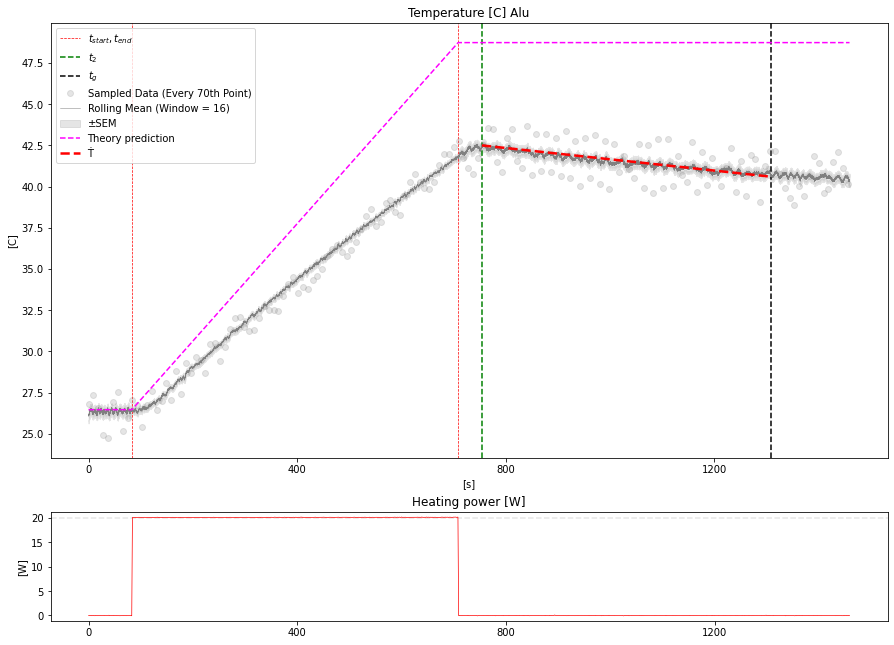

In [67]:
ideal=ideals[name]  #the theory prediciton

fig = plt.figure(figsize=(15, 11)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

#labeling
ax0.set_title(f"Temperature [C] {name}")
ax0.set_ylabel("[C]") 
ax0.set_xlabel("[s]")
ax0.xaxis.set_major_locator(MaxNLocator(x_ticker_count))  
ax0.yaxis.set_major_locator(MaxNLocator(y_ticker_count))
ax1.set_title("Heating power [W]")
plt.axhline(y=20, color='grey', linestyle='--',alpha=0.2)
ax1.xaxis.set_major_locator(MaxNLocator(x_ticker_count))  

ax1.set_ylabel('[W]')

#Lines indicating t_s and t_end (Heating times)
ax0.axvline(x=data['h_start'], color='red', linestyle='--', linewidth=.7,label='$t_{start}, t_{end}$')
ax0.axvline(x=data['h_end'], color='red', linestyle='--', linewidth=.7)


#Times t_2 and t_g
ax0.axvline(x=data['time'][meta['i_end_h']+end_h_step], color='green', linestyle='--', linewidth=1.5,label='$t_2$')
ax0.axvline(x=meta['t_g'], color='black', linestyle='--', linewidth=1.5,label='$t_g$')

#showing some raw temperature datapoints
ax0.plot(data['time'][::a_step], data['temp'][::a_step],'o',alpha=0.2,color='grey',label=f'Sampled Data (Every {a_step}th Point)')

#the rolling average curve
ax0.plot(data['time'], data['smooth_temp'],'-',alpha=1,color='grey',label='Rolling Mean (Window = '+str(window_size)+')',linewidth=.5)

#SEM
ax0.fill_between(data['time'], data["smooth_temp"] - data["sem"],data["smooth_temp"] + data["sem"], color="grey", alpha=.2, label="±SEM")

#Theory prediction
ax0.plot(ideal['time'], ideal['temp'],'--',alpha=1,color='magenta',label='Theory prediction')

#gradient plotting
x = np.linspace(data['time'][meta['i_end_h']+end_h_step], meta['t_g'], 2)   
ax0.plot(x, gradient * x + y_offset,'--',color='red',linewidth=2.5, label=f"Ṫ",)

#Second subplot: the heating.
ax1.plot(data['time'][::b_step], data['power'][::b_step],'-',color='red',linewidth=0.7)

ax0.legend()

## Error calculations

**Inital error**



In [68]:
#error of initial temperature for probe and water
w_d_init_temp = water['sem'][w_meta['i_start_h']]
d_init_temp= data['sem'][meta['i_start_h']]

#error of temperature at t=t_2 for probe 
i_2 = meta['i_end_h']+end_h_step
t_2= data['time'][i_2]
d_temp_2 = data['sem'][i_2]

# ... for water
w_i_2 = w_meta['i_end_h']+end_h_step
w_t_2 = water['time'][w_i_2]
w_d_temp_2 = water['sem'][w_i_2]

#error of temperature at t=t_g for probe and water
d_temp_g = data['sem'][meta['i_g']]
w_d_temp_g = water['sem'][w_meta['i_g']]

error propagation:

In [69]:
#error of delta-t
d_delta_t= errors.delta_t(d_temp_g=d_temp_g,d_init_temp=d_init_temp) 
w_d_delta_t = errors.delta_t(d_temp_g= w_d_temp_g, d_init_temp= w_d_init_temp)

#error of gradient T'
d_gradient = errors.gradient(d_temp_2,t_2,meta['t_start_h'],d_temp_g)
w_d_gradient =errors.gradient(w_d_temp_2,w_t_2,w_meta['t_start_h'],w_d_temp_g)

#error of Integral F using integral errorband 
d_integral_numpy = np.trapz(data['sem'][meta['i_start_h']:meta['i_g']], data['time'][meta['i_start_h']:meta['i_g']])
w_d_inegral_numpy = np.trapz(water['sem'][w_meta['i_start_h']:w_meta['i_g']], water['time'][w_meta['i_start_h']:w_meta['i_g']])

#error of c_add (water)
d_c_add = errors.c_tot(w_energy_input,w_gradient,w_smooth_integral,w_delta_t_g,d_delta_t,w_d_gradient,w_d_inegral_numpy)

#error  of  c_tot 
d_c_tot = errors.c_tot(energy_input,gradient,smooth_integral,delta_t_g,d_delta_t,d_gradient,d_integral_numpy)

#error of c_probe
d_c_probe = errors.probe(d_c_tot,d_c_add)

d_m= 0.05 #error of mass in [g]

#the final error.
d_c_m= errors.c_m(meta,c_probe,d_m,d_c_probe)

## Results

In [70]:
print('** Results **')
print(f'c_m for {name} is ', round(c_m,1)),
print('the error for c_m is +/-',round(d_c_m,1),'\n\n')

print('** Parameters **')
print('window_size ', window_size)
print('stepsize (index) t_end-t_2 ', end_h_step,'\n\n')


print(f'additional data for {name}')
print('initial temp:',initial_temp)
print('delta_temp_t1_tg',delta_t_g)
print('temp_g',temp_g)
print('h_duration',heating_duration)
print('mean_voltage',mean_power/1.7)
print('energy_in',energy_input)
print('gradient',gradient)
print('F ',smooth_integral)
print('c_tot',c_tot)
print('c_add is',c_add)
print(meta)




** Results **
c_m for Alu is  23.0
the error for c_m is +/- 2.2 


** Parameters **
window_size  16
stepsize (index) t_end-t_2  340 


additional data for Alu
initial temp: 26.4190484375
delta_temp_t1_tg 14.180959374999997
temp_g 40.600007812499996
h_duration 625.60003263
mean_voltage 11.84253553100597
energy_in 12594.774044852757
gradient -0.003424278956929925
F  13866.865549185699
c_tot 718.4945480104825
c_add is 382.1927699357854
{'i_start_h': 626, 'i_end_h': 5318, 't_start_h': 82.93333766, 't_end_h': 708.53337029, 'weight': 395.1, 'c': 0.9, 'b_sign': 1, 'water': 209.20000000000002, 't_g': 1308.00006822, 'i_g': 9814, 'M': 26.981}
